In [121]:
import pandas as pd
import numpy as np
import re


from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

sns.set()

In [32]:
review_text = pd.read_csv('./data/movie_reviewtext.csv', encoding='utf-8')
review_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57537 entries, 0 to 57536
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  57537 non-null  object
 1   reviews   57537 non-null  object
dtypes: object(2)
memory usage: 899.1+ KB


In [17]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags

    Provided by Flatiron School
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [157]:
sw = stopwords.words('english')

tokenizer = RegexpTokenizer('\w+')

lemmer = WordNetLemmatizer()

regex_template = r"[^\w\s]"

In [158]:
def preprocess_and_lemmatize(text):
    text = re.sub(regex_template, '', text)
    
    text = text.lower()

    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]

    lemmatized_words = [lemmer.lemmatize(word, pos=get_wordnet_pos(tag))
                        for word, tag in pos_tag(words)]
    
    return ' '.join(lemmatized_words)


In [159]:
def tokenize_sw(text):
    
    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]
    
    return words


In [160]:
def remove_sw(text):
    
    words = text

    words = [word for word in words if word not in sw]
    
    return words

In [161]:
df_rev_stop = review_text.copy()

In [162]:
df_rev_stop['reviews'] = df_rev_stop['reviews'].apply(preprocess_and_lemmatize)
df_rev_stop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57537 entries, 0 to 57536
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  57537 non-null  object
 1   reviews   57537 non-null  object
dtypes: object(2)
memory usage: 899.1+ KB


In [153]:
df_rev_stop.head()

,movie_id,reviews
0,0005092663,"[learn, ended, state, dying, country, excellen..."
1,0005097258,"[arrived, perfect, condition, course, could, n..."
2,0005114349,"[kind, hoaky, somewhat, entertaining, ok, titl..."
3,0307142493,"[daughter, liked, santa, claus, knows, chris, ..."
4,0310271908,"[deeper, connection, bible, studies, really, w..."


In [84]:
def freq_plot(data, value_column, n_words=15, theme=None):
    fig, ax = plt.subplots(figsize=(12, 4))

    plotted_words_and_colors = {}
    color_palette = sns.color_palette(theme, n_colors=n_words)

    all_words_ = data[value_column].explode()
    top_all = all_words_.value_counts()[:n_words]

    colors = []
    for word in top_all.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
        
    ax.bar(top_all.index, top_all.values, color=colors)
    ax.set_title("Top Words")
    plt.xticks(rotation=15)
    plt.tight_layout()



In [163]:
df_rev_st = df_rev_stop.copy()

In [164]:
df_rev_st['reviews'] = df_rev_st['reviews'].apply(tokenize_sw)
df_rev_st.head()

,movie_id,reviews
0,0005092663,"[watch, learn, end, state, die, country, excel..."
1,0005097258,"[arrive, perfect, condition, course, could, ne..."
2,0005114349,"[kind, hoaky, somewhat, entertaining, ok, grea..."
3,0307142493,"[daughter, like, santa, claus, movie, know, ch..."
4,0310271908,"[deep, connection, bible, study, really, great..."


In [166]:
df_rev_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57537 entries, 0 to 57536
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  57537 non-null  object
 1   reviews   57537 non-null  object
dtypes: object(2)
memory usage: 899.1+ KB


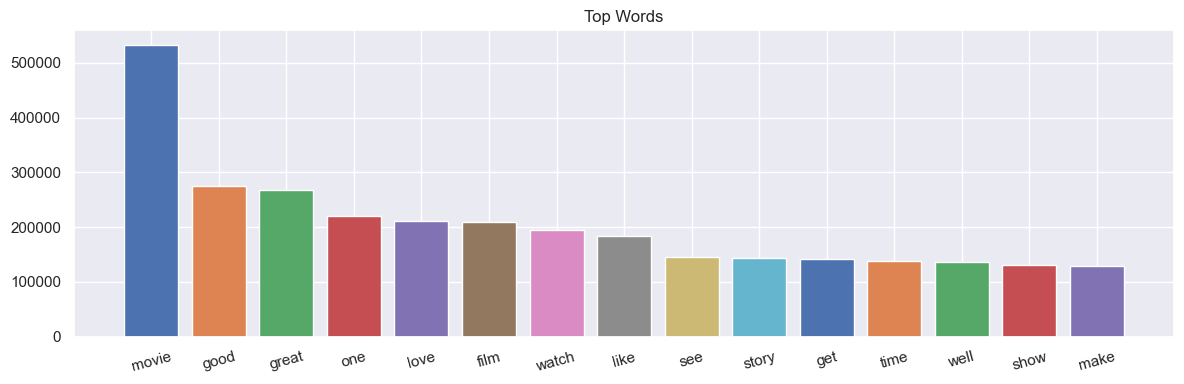

In [165]:
freq_plot(df_rev_st, 'reviews')

In [171]:
sw = stopwords.words('english')
specific_words = [
    'movie','good','great',
    'film','watch', 'like',
    'see', 'story', 'get',
    'show'
]

sw.extend(specific_words)

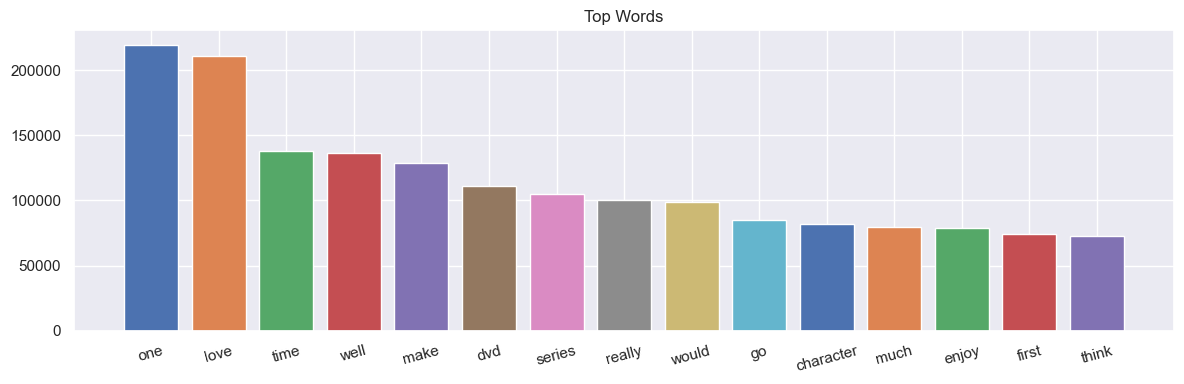

In [172]:
df_rev_st['reviews'] = df_rev_st['reviews'].apply(remove_sw)
freq_plot(df_rev_st, 'reviews')

In [173]:
sw = sw.copy()

more_words = [
    'one', 'love', 'dvd',
    'DVD', 'series'
    ]
sw.extend(more_words)

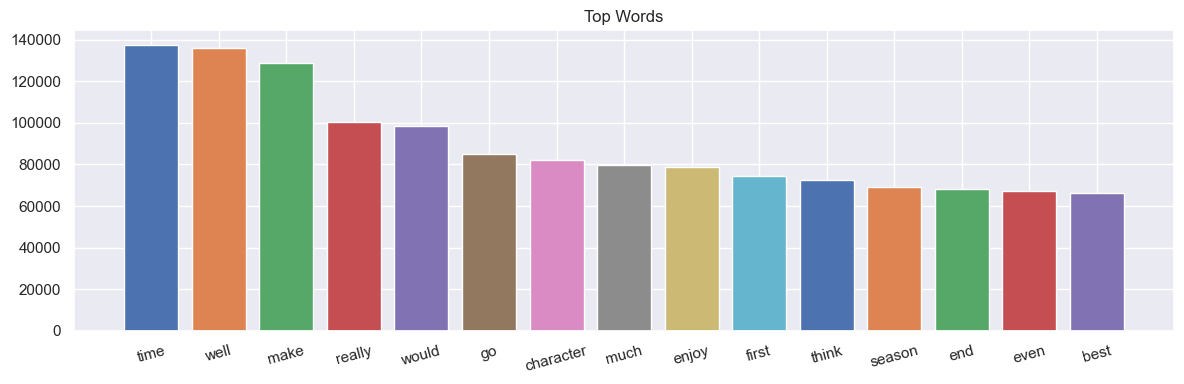

In [174]:
df_rev_st['reviews'] = df_rev_st['reviews'].apply(remove_sw)
freq_plot(df_rev_st, 'reviews')

In [263]:
df_rev_clean = df_rev_st.copy()
df_rev_clean['reviews'] = df_rev_clean['reviews'].apply(lambda x: ' '.join(x))
df_rev_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57537 entries, 0 to 57536
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  57537 non-null  object
 1   reviews   57537 non-null  object
dtypes: object(2)
memory usage: 899.1+ KB


In [209]:
vector = TfidfVectorizer(max_features=400)
tf_genre = vector.fit_transform(df_rev_clean['reviews'])
tf_genre = pd.DataFrame(tf_genre.todense(), columns=vector.get_feature_names_out(), index=df_rev_clean['movie_id']).reset_index()
tf_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57537 entries, 0 to 57536
Columns: 401 entries, movie_id to youre
dtypes: float64(400), object(1)
memory usage: 176.0+ MB


In [273]:
vector = TfidfVectorizer(max_features=250)
tf_star = vector.fit_transform(df_rev_clean['reviews'])

tf_star = pd.DataFrame(tf_star.todense(), columns=vector.get_feature_names_out(), index=df_rev_clean['movie_id']).reset_index()
tf_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57537 entries, 0 to 57536
Columns: 251 entries, movie_id to youre
dtypes: float64(250), object(1)
memory usage: 110.2+ MB


In [231]:
df_content = pd.read_csv('./data/content_genres_cleaned.csv')
df_content.rename(columns = {'title':'Movie_Title'}, inplace=True)
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57704 entries, 0 to 57703
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   genre        57704 non-null  object 
 1   description  53816 non-null  object 
 2   Movie_Title  57696 non-null  object 
 3   starring     57704 non-null  object 
 4   rank         57624 non-null  float64
 5   movie_id     57704 non-null  object 
 6   english      57704 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 3.1+ MB


In [232]:
df_meta = df_content.copy()
df_meta.drop(columns = ['description', 'rank', 'english'], inplace=True)
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57704 entries, 0 to 57703
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        57704 non-null  object
 1   Movie_Title  57696 non-null  object
 2   starring     57704 non-null  object
 3   movie_id     57704 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [261]:
allid = tf_genre['movie_id'].unique().tolist()
defcon = df_meta[df_meta['movie_id'].isin(allid)]
defcon.drop(columns = ['starring'], inplace=True)
defcon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57537 entries, 0 to 57703
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        57537 non-null  object
 1   Movie_Title  57537 non-null  object
 2   movie_id     57537 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


C:\Users\raxmo\AppData\Local\Temp\ipykernel_15300\66592968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defcon.drop(columns = ['starring'], inplace=True)


In [234]:
revtext_nostar = pd.merge(defcon, tf_genre, on="movie_id", how="left")
revtext_nostar.set_index('movie_id', inplace=True)
revtext_nostar = pd.get_dummies(revtext_nostar, columns=['genre'])
revtext_nostar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57537 entries, 0005114349 to B01HJ6R77G
Columns: 429 entries, Movie_Title to genre_Westerns
dtypes: bool(28), float64(400), object(1)
memory usage: 178.0+ MB


In [274]:
allid2 = tf_star['movie_id'].unique().tolist()
defcon2 = df_meta[df_meta['movie_id'].isin(allid)]
defcon2.drop(columns = ['genre'], inplace=True)
defcon2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57537 entries, 0 to 57703
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Movie_Title  57537 non-null  object
 1   starring     57537 non-null  object
 2   movie_id     57537 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


C:\Users\raxmo\AppData\Local\Temp\ipykernel_15300\2202923452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defcon2.drop(columns = ['genre'], inplace=True)


In [281]:
top_250_starring = defcon2['starring'].value_counts().nlargest(250).index


df_nogenre = defcon2[defcon2['starring'].isin(top_250_starring)]
df_nogenre = df_nogenre[df_nogenre['starring'] != 'Various Artists']


revtext_nogen = pd.merge(df_nogenre, tf_star, on="movie_id", how="left")
revtext_nogen.set_index('movie_id', inplace=True)
revtext_nogen = pd.get_dummies(revtext_nogen, columns=['starring'])
revtext_nogen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4915 entries, 0307142493 to B01HHGAIHE
Columns: 500 entries, Movie_Title to starring_Yuri Lowenthal
dtypes: bool(249), float64(250), object(1)
memory usage: 10.6+ MB


In [257]:
def cos_recs_genre(movie_id):

    cosine_matrix = cosine_similarity(revtext_nostar.drop('Movie_Title', axis=1))

    similarity_scores = pd.Series(cosine_matrix[revtext_nostar.index.get_loc(movie_id)], index=revtext_nostar.index)

    sorted_scores = similarity_scores.sort_values(ascending=False)

    top_recommendations = sorted_scores.loc[sorted_scores.index != movie_id].head(5)

    recommended_movies = df_content[df_content['movie_id'].isin(top_recommendations.index)]

    return recommended_movies

In [254]:
def knn_recs_genre(movie_id):
    features = revtext_nostar.drop('Movie_Title', axis=1)

    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    model.fit(features.values)

    distances, indices = model.kneighbors(features.loc[movie_id].to_numpy().reshape(1, -1), return_distance=True)

    top_recommendations = [revtext_nostar.index[i] for i in indices[0][1:]]

    recommended_movies = df_content[df_content['movie_id'].isin(top_recommendations)]

    return recommended_movies

In [258]:
cosine_recommendations_genre = cos_recs_genre('0307142493')
cosine_recommendations_genre

,genre,description,Movie_Title,starring,rank,movie_id,english
1354,Science Fiction & Fantasy,Mrs. Claus tells us about the time Santa had a...,Year Without Santa Claus VHS,Shirley Booth,420162.0,6302503795,1
1773,Science Fiction & Fantasy,Disney and Touchstone team up with Tim Burton ...,Tim Burton's The Nightmare Before Christmas VHS,Danny Elfman,96727.0,6303122647,1
3386,Science Fiction & Fantasy,This DVD has two movies on it for the price of...,How the Grinch Stole Christmas / Horton Hears ...,Boris Karloff,132103.0,6304698771,1
15696,Science Fiction & Fantasy,<![CDATA[ Polar Express: Special Edition (Dbl ...,The Polar Express,Nona Gaye,36095.0,B0009XRZ9M,1
33668,Science Fiction & Fantasy,Celebrate the holidays with MICKEY'S CHRISTMAS...,Disney Animation Collection 7: Mickey's Christ...,Edward Brophy,34077.0,B0029ZUQB2,1


In [255]:
knn_recommendations_genre = knn_recs_genre('0307142493')
knn_recommendations_genre

,genre,description,Movie_Title,starring,rank,movie_id,english
1354,Science Fiction & Fantasy,Mrs. Claus tells us about the time Santa had a...,Year Without Santa Claus VHS,Shirley Booth,420162.0,6302503795,1
1773,Science Fiction & Fantasy,Disney and Touchstone team up with Tim Burton ...,Tim Burton's The Nightmare Before Christmas VHS,Danny Elfman,96727.0,6303122647,1
3386,Science Fiction & Fantasy,This DVD has two movies on it for the price of...,How the Grinch Stole Christmas / Horton Hears ...,Boris Karloff,132103.0,6304698771,1
15696,Science Fiction & Fantasy,<![CDATA[ Polar Express: Special Edition (Dbl ...,The Polar Express,Nona Gaye,36095.0,B0009XRZ9M,1
33668,Science Fiction & Fantasy,Celebrate the holidays with MICKEY'S CHRISTMAS...,Disney Animation Collection 7: Mickey's Christ...,Edward Brophy,34077.0,B0029ZUQB2,1


In [282]:
def cos_recs_star(movie_id):

    cosine_matrix = cosine_similarity(revtext_nogen.drop('Movie_Title', axis=1))

    similarity_scores = pd.Series(cosine_matrix[revtext_nogen.index.get_loc(movie_id)], index=revtext_nogen.index)

    sorted_scores = similarity_scores.sort_values(ascending=False)

    top_recommendations = sorted_scores.loc[sorted_scores.index != movie_id].head(5)

    recommended_movies = df_content[df_content['movie_id'].isin(top_recommendations.index)]

    return recommended_movies

In [283]:
def knn_recs_star(movie_id):
    features = revtext_nogen.drop('Movie_Title', axis=1)

    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    model.fit(features.values)

    distances, indices = model.kneighbors(features.loc[movie_id].to_numpy().reshape(1, -1), return_distance=True)

    top_recommendations = [revtext_nogen.index[i] for i in indices[0][1:]]

    recommended_movies = df_content[df_content['movie_id'].isin(top_recommendations)]

    return recommended_movies

In [284]:
cosine_recommendations_starring = cos_recs_star('0307142493')
cosine_recommendations_starring

,genre,description,Movie_Title,starring,rank,movie_id,english
7227,Science Fiction & Fantasy,THIS STORY TELLS HOW KRIS KRINGLE GOT HIS STAR...,Santa Claus Is Comin' To Town/The Little Drumm...,Fred Astaire,88649.0,B00005MEV0,1
7234,Science Fiction & Fantasy,The original television holiday classics dvd c...,Santa Claus is Comin' to Town / The Little Dru...,Fred Astaire,181227.0,B00005MEUZ,1
19798,Science Fiction & Fantasy,The Ultimate Holiday Entertainment Collection!...,Christmas Classics - The Original Television C...,Fred Astaire,60421.0,B000GFRI7W,1
36965,Musicals,THE GAY DIVORCEE (1934) Oscar winner* The Cont...,TCM Greatest Classic Film Collection: Astaire ...,Fred Astaire,10672.0,B00406UJZG,1
43620,Comedy,"In one classic collection, these 20 films call...",20-Film Hollywood Greats V.2,Fred Astaire,128661.0,B0080QOKVG,1


In [285]:
knn_recommendations_starring = knn_recs_star('0307142493')
knn_recommendations_starring

,genre,description,Movie_Title,starring,rank,movie_id,english
7227,Science Fiction & Fantasy,THIS STORY TELLS HOW KRIS KRINGLE GOT HIS STAR...,Santa Claus Is Comin' To Town/The Little Drumm...,Fred Astaire,88649.0,B00005MEV0,1
7234,Science Fiction & Fantasy,The original television holiday classics dvd c...,Santa Claus is Comin' to Town / The Little Dru...,Fred Astaire,181227.0,B00005MEUZ,1
19798,Science Fiction & Fantasy,The Ultimate Holiday Entertainment Collection!...,Christmas Classics - The Original Television C...,Fred Astaire,60421.0,B000GFRI7W,1
36965,Musicals,THE GAY DIVORCEE (1934) Oscar winner* The Cont...,TCM Greatest Classic Film Collection: Astaire ...,Fred Astaire,10672.0,B00406UJZG,1
43620,Comedy,"In one classic collection, these 20 films call...",20-Film Hollywood Greats V.2,Fred Astaire,128661.0,B0080QOKVG,1


In [297]:
# def knn_recs_genre_weighted(movie_id):
#     features = revtext_nostar.drop('Movie_Title', axis=1)

#     weighted_cosine_matrix = np.zeros((len(features), len(features)))
#     for i in range(len(features)):
#         for j in range(i+1, len(features)):
#             diff = np.abs(features.iloc[i].astype(int) - features.iloc[j].astype(int))
#             numerator = diff.sum()
#             denominator = (np.sqrt((features.iloc[i]**2).sum()) * np.sqrt((features.iloc[j]**2).sum()))
#             if denominator != 0:
#                 weighted_cosine_matrix[i][j] = 1 - (numerator / denominator)
#                 weighted_cosine_matrix[j][i] = weighted_cosine_matrix[i][j]

#     distances, indices = [], []
#     for i in range(len(features)):
#         distances.append(weighted_cosine_matrix[revtext_nostar.index.get_loc(movie_id)][i])
#         indices.append(i)

#     sorted_scores = pd.Series(distances, index=revtext_nostar.index)
#     top_recommendations = sorted_scores.sort_values(ascending=False).loc[sorted_scores.index != movie_id].head(5)

#     recommended_movies = df_content[df_content['movie_id'].isin(top_recommendations.index)]

#     return recommended_movies

In [298]:
# weighted_knn_recs = knn_recs_genre_weighted('0307142493')
# weighted_knn_recs